# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

**Objetivos del negocio**
* Se requiere realizar un modelo de prediccion para un dealer de autos usados para el calculo de precio dependiendo de ciertas caracteristicas del vehiculo, con el fin de incrementar sus ventas comprando por debajo de lo que cuesta el vehículo y vendiendo a sobreprecio
* Segmentar los vehículos para comprar los vehiculos que le dejen mayor utilidad
* Utilizar campañas de marketing para promocionar los vehículos más atractivos.


**Recoleccion de datos**
Los datos son recabados de un dataSet de Kaggle con información de autos usados de diferntes regiones de EEUU con attributos necesarios para detarminar el costo del vehiculo.

**Plan del proyecto**
1. Recolección de datos
2. Limpieza de datos
3. Análisis de datos para entender mejor los datos y detectar similitudes
4. Desarrollo de modelos predictivos
5. Evaluación de modelos
6. Implementacion de modelos

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [21]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV


#os.listdir('data/')
vehicles_df = pd.read_csv('data/vehicles.csv')

## File Information
# - Archivo:	Vehicles.csv
# - Registros:	426880
# - Atributos:	17

## Descripción de los atributos (CodeBook)
1. **id**: Identificador único para el vehículo.
2. **region**: Región o área donde el producto se encuentra
3. **price**: Precio del vehículo en dólares
4. **year**: Año de producción del vehículo
5. **manufacturer**: Marca del vehículo (Ejemplo: Ford, Chevrolet, Toyota, Honda, BMW, etc.)
6. **model**: Modelo del vehículo (Ejemplo: Focus, Aveo, Yaris, HRV, etc)
7. **condition**: Condición del vehículo en la que se encuentra(Ejemplo: Nuevo, Como nuevo, Usado, etc.).
8. **cylinders**: Número de cilindros del motor(Ejemplo: 4 Cilindros, 6 Cilindros).
9. **fuel**: Tipo de combustible (Ejemplo: Gasolina, Diesel, Eléctrico).
10. **odometer**: Kilometraje del vehículo.
11. **title_status**: Estatus del vehiculo (Ejemplo. Original, Reconstruido).
12. **transmission**: Tipo de transmisión (Ejemplo: Manual, Automatico).
13. **VIN**: Número de identificación del vehículo.
14. **drive**: Tipo de tren motriz (Ejemplo: 4wd, fwd, rwd).
15. **size**: Tamaño del Type of drive train(Ejemplo: Compacto, Grande).
16. **type**: Tipo del Type of drive train (Ejemplo: Sedan, SUV, miniSUV, Camión).
17. **paint_color**: Pintura exterior del Type of drive train.
18. **state**: Estado de los USA donde se encuentra el vehículo.

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

**Pasos Understanding**
1.- Identificar y manejar valores faltantes
2.- Conversión de tipos de datos
3.- Eliminar duplicados
4.- Estudio y tratamiento de outliers
5.- Estandarización de categorías

In [2]:
#Paso 1
########################################################################################
# Eliminando columnas con muchos valores faltantes
vehicles_df.drop(columns=['VIN', 'size', 'paint_color', 'id'], inplace=True)
# Eliminando filas donde los valores de price, year esten vacios
vehicles_df.dropna(subset=['price', 'year'], inplace=True)
# Los valorse faltantes en los campos 'manufacturer', 'model', 'condition', 'fuel', y 'transmission' rellenarlos con "Unknown"
for column in ['manufacturer', 'model', 'condition', 'fuel', 'transmission', 'cylinders']:
    most_frequent_value = vehicles_df[column].mode()[0]  # Calcula la moda de la columna
    vehicles_df[column] = vehicles_df[column].fillna(most_frequent_value)

# Paso 2
########################################################################################
vehicles_df['price'] = pd.to_numeric(vehicles_df['price'], errors='coerce')
vehicles_df['year'] = pd.to_numeric(vehicles_df['year'], errors='coerce')

# Confirm the cleaning steps by displaying the remaining null values, types, and summary statistics
cleaned_missing_values = vehicles_df.isnull().sum()
cleaned_data_types = vehicles_df.dtypes
cleaned_summary_statistics = vehicles_df[['price', 'year', 'odometer']].describe()

# Paso 3
########################################################################################
vehicles_df = vehicles_df.drop_duplicates()

# Paso 4
########################################################################################
# Remover valores atipicos o fuera de rango en los atributos "precio", "odometro"
# se establece el rango de precio de los vehiculos entre 10000 y 150,000
# se estalece el odometro menor a los 500000
vehicles_df = vehicles_df[(vehicles_df['price'] > 10000) & (vehicles_df['price'] < 150000)]
vehicles_df = vehicles_df[(vehicles_df['odometer'] < 500000) | (vehicles_df['odometer'].isna())]
# rellenar valores perdidos de odometro con la media
most_frequent_value = vehicles_df['odometer'].mode()[0]  # Calcula la moda de la columna
vehicles_df['odometer'] = vehicles_df['odometer'].fillna(most_frequent_value)

In [3]:
# Validando
missing_values = vehicles_df.isnull().sum()

# 2: Conversión de tipos de datos (Price, year, etc)
data_types = vehicles_df.dtypes

# 3: Eliminar duplicados
duplicates = vehicles_df.duplicated().sum()

# 4: Estudio y tratamiento de outliers (price, year, odometer)
summary_statistics = vehicles_df[['price', 'year', 'odometer', 'manufacturer']].describe()

#missing_values, data_types, duplicates, summary_statistics

In [ ]:
# Aplicando One-Hot Encoding en el Dataset vehicles_df
vehicles_encoded_df = pd.get_dummies(vehicles_df, columns=['transmission', 'cylinders'])

In [5]:
vehicles_encoded_df.drop(columns=['region', 'drive', 'model'], inplace=True)
#vehicles_encoded_df

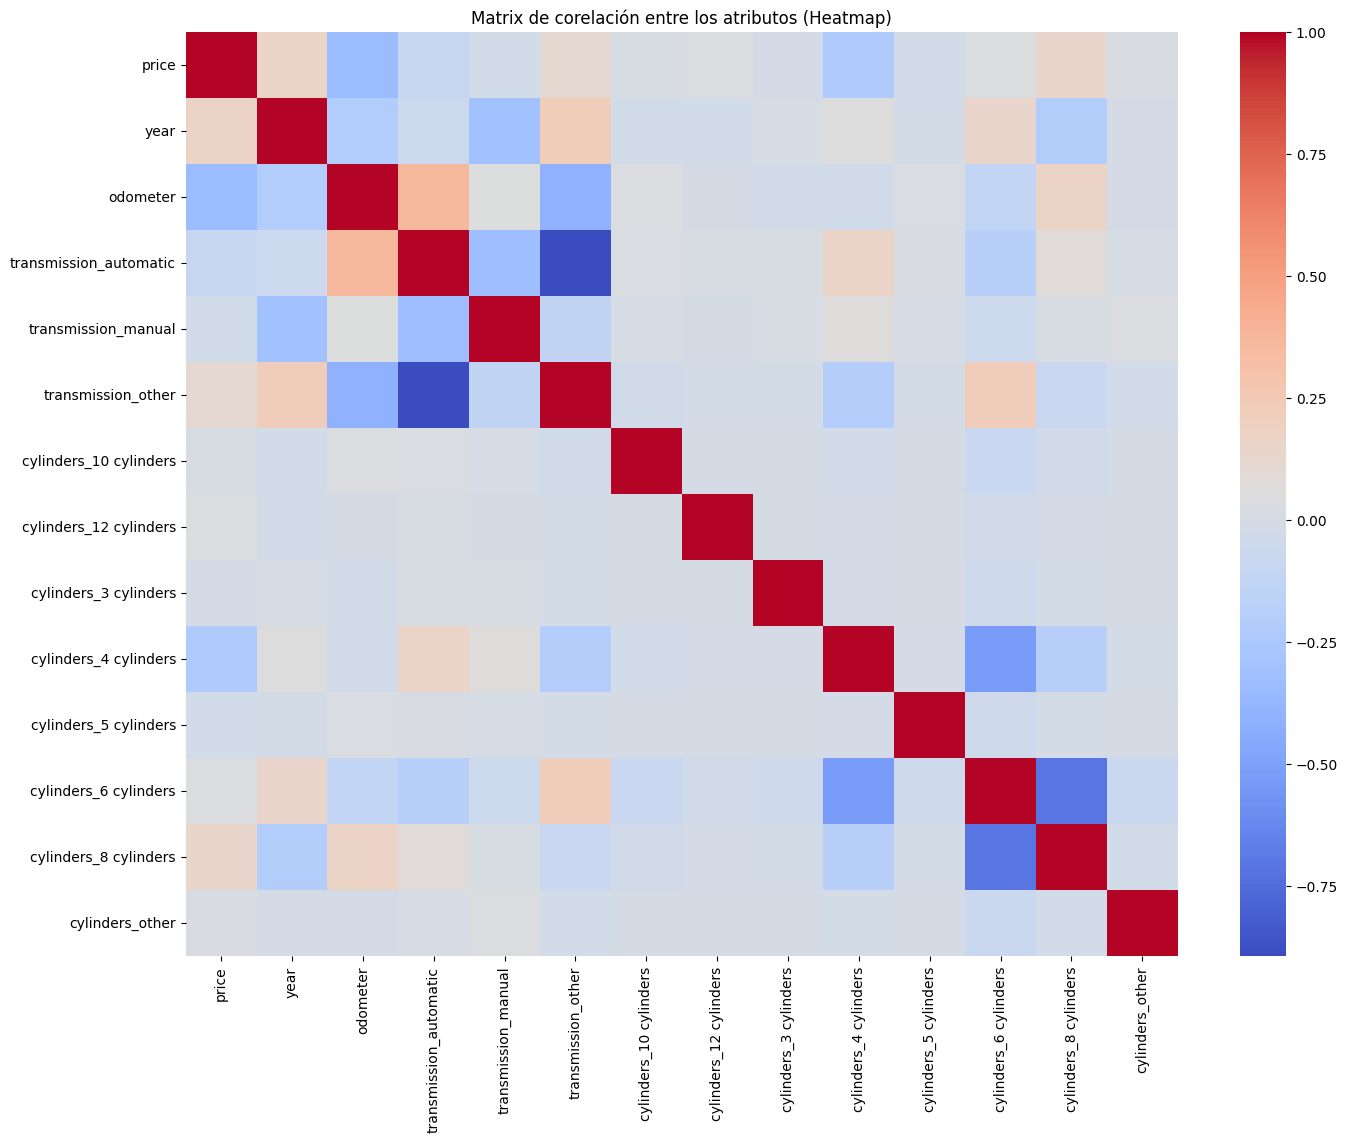

In [6]:
#Visualizaciones de los datos
# Matriz de correlacion para identificar cuales son los atributos mas influyentes al precio
correlation_matrix = vehicles_encoded_df.corr(numeric_only=True)

# Para esa matrix se utilizando los atributos numericos
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title("Matrix de corelación entre los atributos (Heatmap)")
plt.show()


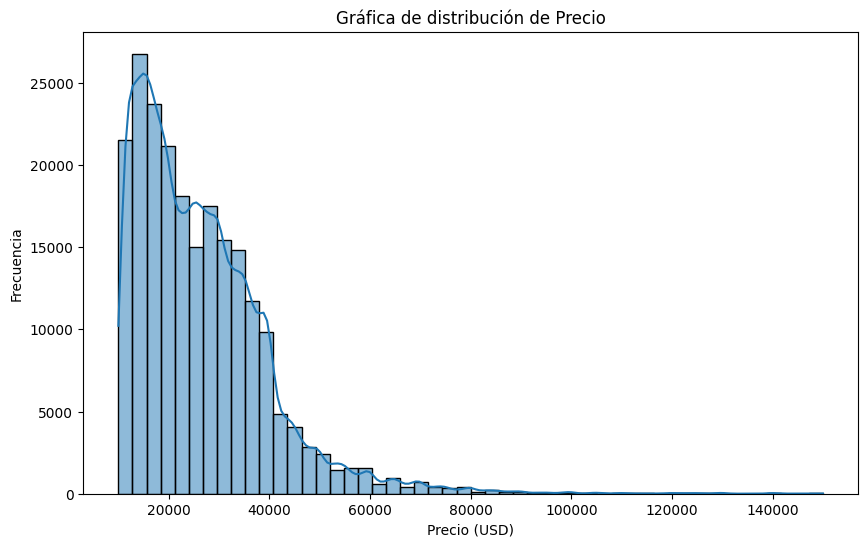

In [7]:
# Plot distribution of price
plt.figure(figsize=(10, 6))
sns.histplot(vehicles_encoded_df['price'], bins=50, kde=True)
plt.title('Gráfica de distribución de Precio')
plt.xlabel('Precio (USD)')
plt.ylabel('Frecuencia')
plt.show()

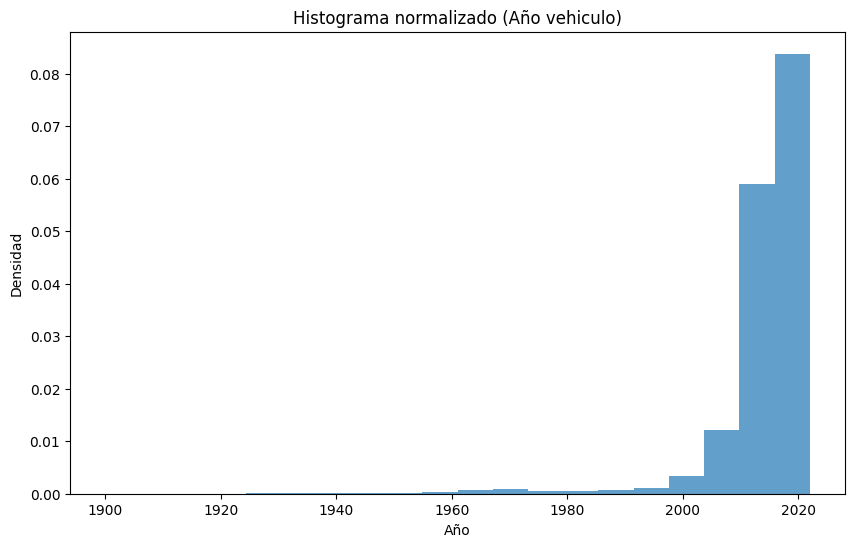

In [8]:
# graficando el año
plt.figure(figsize=(10, 6))
vehicles_encoded_df['year'].plot(kind='hist', bins=20, density=True, alpha=0.7)
plt.xlabel("Año")
plt.ylabel("Densidad")
plt.title("Histograma normalizado (Año vehiculo)")
plt.show()


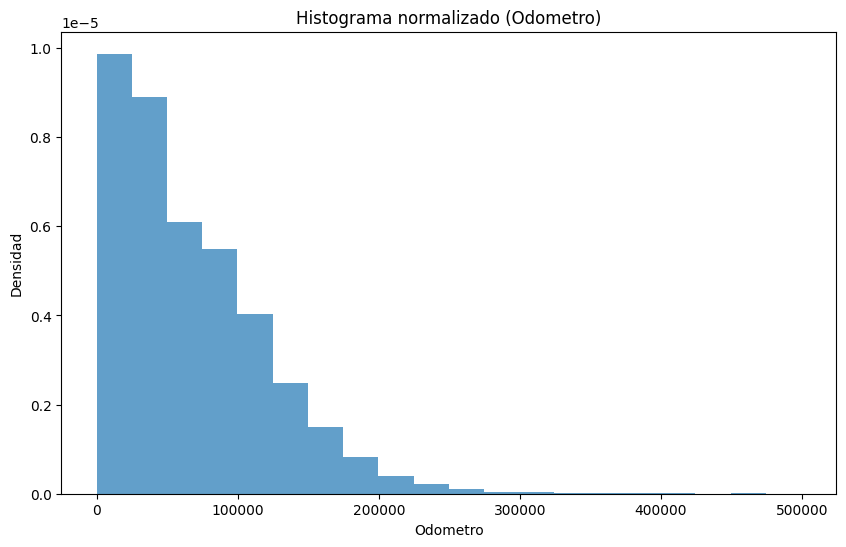

In [9]:
# graficando el Odometro
plt.figure(figsize=(10, 6))
vehicles_encoded_df['odometer'].plot(kind='hist', bins=20, density=True, alpha=0.7)
plt.xlabel("Odometro")
plt.ylabel("Densidad")
plt.title("Histograma normalizado (Odometro)")
plt.show()

<Figure size 1000x600 with 0 Axes>

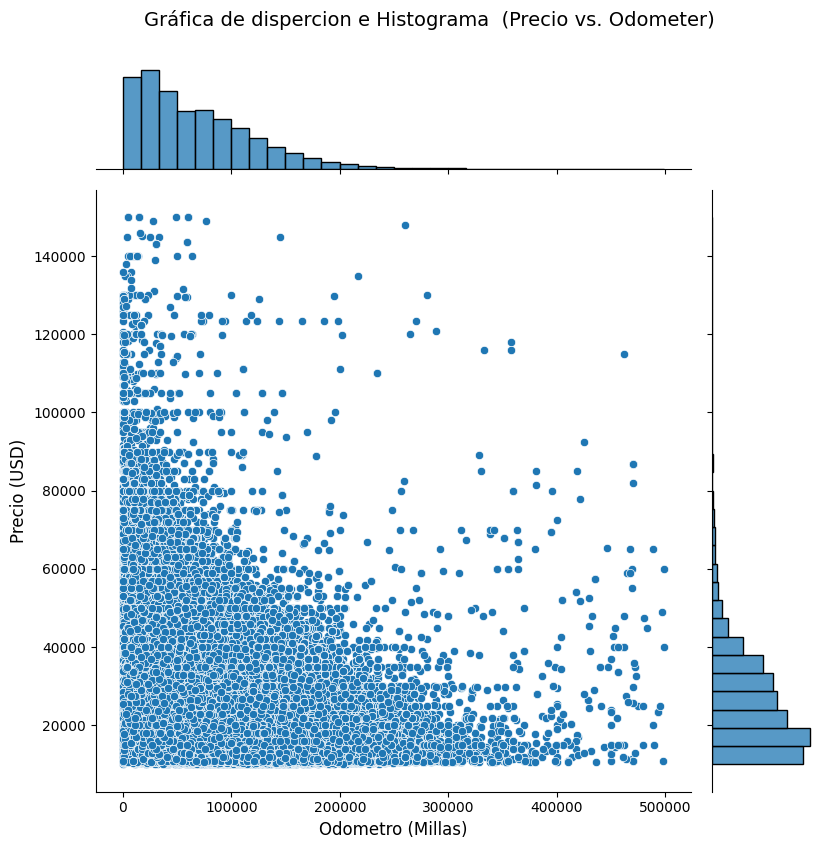

In [10]:
# Creating a scatter plot with a marginal histogram using seaborn
plt.figure(figsize=(10, 6))
sns.jointplot(x='odometer', y='price', data=vehicles_encoded_df, kind='scatter', height=8, marginal_kws=dict(bins=30, fill=True))
plt.suptitle("Gráfica de dispercion e Histograma  (Precio vs. Odometer)", y=1.05, fontsize=14)
plt.xlabel("Odometro (Millas)", fontsize=12)
plt.ylabel("Precio (USD)", fontsize=12)
plt.show()

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [13]:
# seleccionar las caracteristicas princiapales y el target
features = ['year', 'odometer', 'fuel', 'condition', 'manufacturer']
target = 'price'

# Filtrando dataset con las columnas requeridas
vehicles_model_data = vehicles_encoded_df[features + [target]].dropna()

# Divider los datos entre entrenamiento y prueba
X = vehicles_model_data[features]
y = vehicles_model_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Construyendo los pasos para Regresion lineal
# OneHotEncode "Fuel"
preprocessor = ColumnTransformer(
    transformers=[
        ('fuel', OneHotEncoder(), ['fuel'])
        ,('condition', OneHotEncoder(), ['condition'])
        ,('manufacturer', OneHotEncoder(), ['manufacturer'])
    ],
    remainder='passthrough'  # Keep other columns as is
)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', LinearRegression())])

# Entrenando el modelo
pipeline.fit(X_train, y_train)

# Predicciones del modelo
y_pred = pipeline.predict(X_test)

# Evaluando el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2


(np.float64(123854271.72885312), 0.30638241394237)

In [15]:
# Realizando validación cruzada de modelos

# Configuración del modelo y pipeline
features_kfold = ['year', 'odometer', 'fuel', 'manufacturer', 'condition'] 
target_kfold = 'price'
vehicles_model_data_kfold = vehicles_df[features_kfold + [target_kfold]].dropna()
X_kfold = vehicles_model_data_kfold[features_kfold]
y_kfold = vehicles_model_data_kfold[target_kfold]

# Procesamiento de variables categóricas
preprocessor_kfold = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(), ['fuel', 'manufacturer', 'condition'])], #'transmission', 'drive'
    remainder='passthrough'
)

# Pipeline y validación cruzada
pipeline_kfold = Pipeline(steps=[('preprocessor', preprocessor_kfold), 
                                 ('model', RandomForestRegressor(n_estimators=100, random_state=42))])

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_kfold = cross_val_score(pipeline_kfold, X_kfold, y_kfold, cv=kf, scoring='r2', n_jobs=-1)

# Resultados
print(f"Calificación Media R²: {cv_scores_kfold.mean():.4f}")


Calidificacion Media R²: -167663.8705


In [16]:
# Fit the model
pipeline_kfold.fit(X_kfold, y_kfold)

# Make predictions on the test set
y_pred = pipeline.predict(X_kfold)
r2 = r2_score(y_kfold, y_pred)

print(f"Calificación Media R²: {r2}")

Calificación Media R²: -2.189531696039637e-05


In [ ]:
#Grid Search Hyperparameter

# Configuración de variables y pipeline
features_grid = ['year', 'odometer', 'fuel', 'manufacturer', 'condition']
target_grid = 'price'
vehicles_model_data_grid = vehicles_encoded_df[features_grid + [target_grid]].dropna()
X_grid = vehicles_model_data_grid[features_grid]
y_grid = vehicles_model_data_grid[target_grid]

preprocessor_grid = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(), ['fuel', 'manufacturer', 'condition'])],
    remainder='passthrough'
)
pipeline_grid = Pipeline(steps=[('preprocessor', preprocessor_grid), 
                                ('model', RandomForestRegressor(random_state=42))])

# Configuración de parámetros para el Grid Search
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5, 10]
}

# Inicialización y ajuste de GridSearchCV
grid_search = GridSearchCV(pipeline_grid, param_grid=param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_grid, y_grid)

# Mejor configuración y puntaje
print("Mejores parametros:", grid_search.best_params_)
print("Mejor calificación R²:", grid_search.best_score_)


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

Los modelos requieren mayor ajuste y analisis para determinar el precio correcto, sin embargo ya dan una clara tendendia de que los atributos para determinar le precio son:
1. year (año)
2. odometer (kilometraje)
3. manufacter (marca)
4. condition (condicion)

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

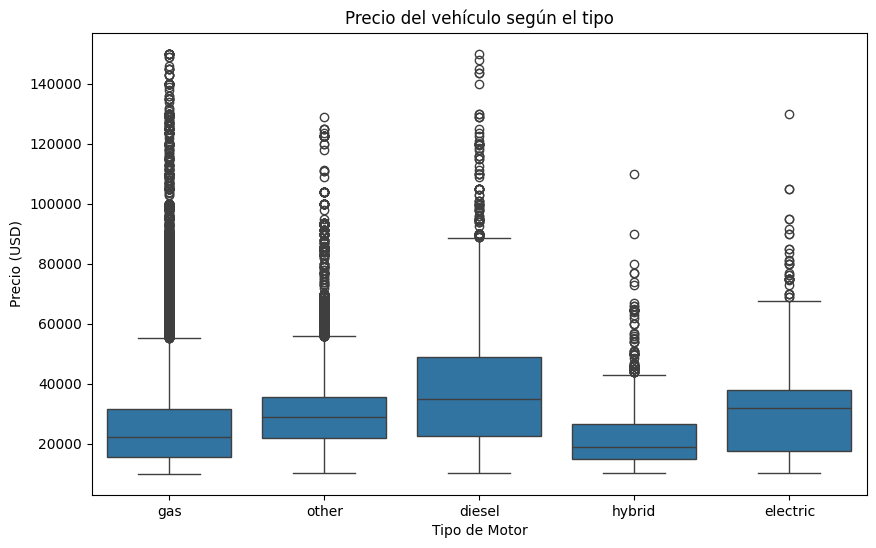

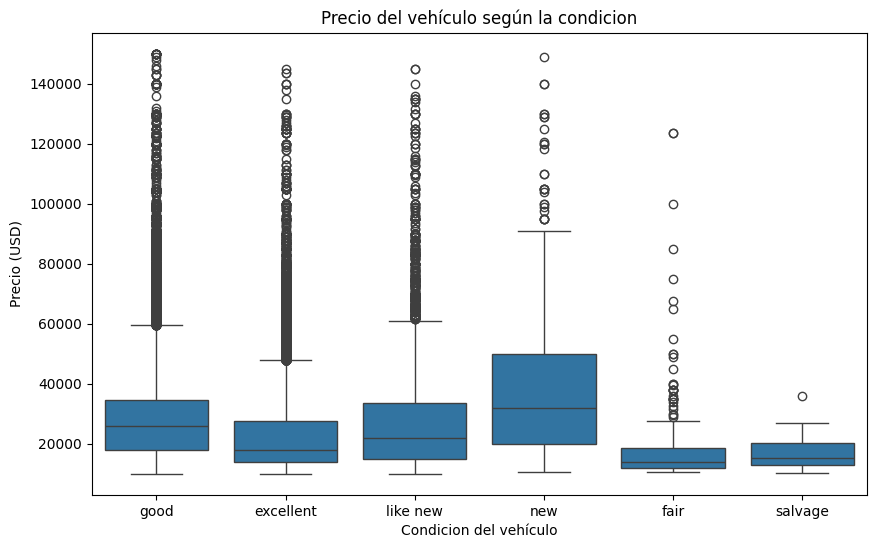

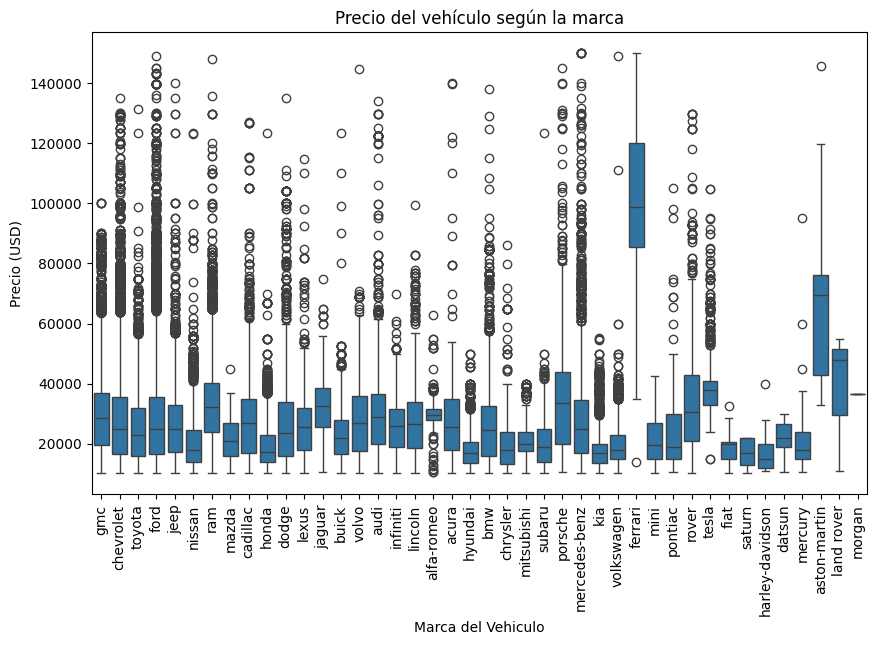

In [19]:
# Box Plor de precio segun el tipo de vehículo
plt.figure(figsize=(10, 6))
sns.boxplot(data=vehicles_encoded_df, x='fuel', y='price')
plt.title('Precio del vehículo según el tipo')
plt.xlabel('Tipo de Motor')
plt.ylabel('Precio (USD)')
plt.show()

# Box Plor de precio segun el tipo de vehículo
plt.figure(figsize=(10, 6))
sns.boxplot(data=vehicles_encoded_df, x='condition', y='price')
plt.title('Precio del vehículo según la condicion')
plt.xlabel('Condicion del vehículo')
plt.ylabel('Precio (USD)')
plt.show()

# Box Plor de precio segun el tipo de vehículo
plt.figure(figsize=(10, 6))
sns.boxplot(data=vehicles_encoded_df, x='manufacturer', y='price')
plt.title('Precio del vehículo según la marca')
plt.xlabel('Marca del Vehiculo')
plt.xticks(rotation=90)
plt.ylabel('Precio (USD)')
plt.show()